In [39]:
import ICUCamera as icuc
import os
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import cv2
from astropy.io import fits
fname = "./example_data/Camera-Run_IIB_string88_mDOM_port5255_cam1_illum1_gain0_exposure2100ms_20260107-20-09-31.raw"

# How to read Header

In [37]:
header = icuc.header_info(fname)
print(header)

Decompressing 1307462 bytes of compressed image data
Image length: 2605672 B
                Record type: 0xAF
                ICM timestamp: 5144824280657
                Encoding desc: 192
                DP status: 0x43
                Camera ID: 04436228050221a
                Camera number: 1
                Capture mode: 0
                Custom window: 0, 0, 0, 0, 0
                Gain: 0
                Conversion mode: 0
                Inversion mode: 0
                Exposure: 2100 msec
                Enable mask: 0x03
                Heater status: off


# Rawfile -> Numpy


Decompressing 1307462 bytes of compressed image data
image size: 1312 * 993


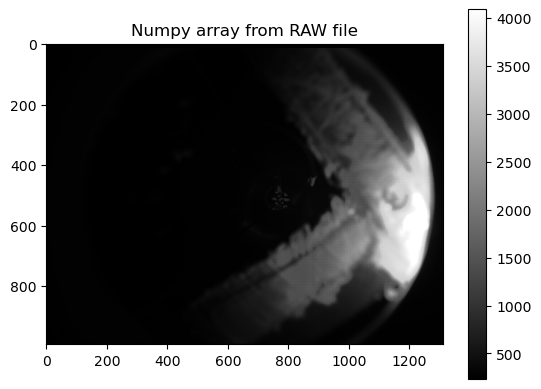

<Figure size 640x480 with 0 Axes>

In [38]:
shape, npy = icuc.Raw2Npy(fname)
plt.imshow(npy, cmap='gray')
plt.colorbar()
plt.title('Numpy array from RAW file')
plt.show()
plt.clf()

# Channel splitting

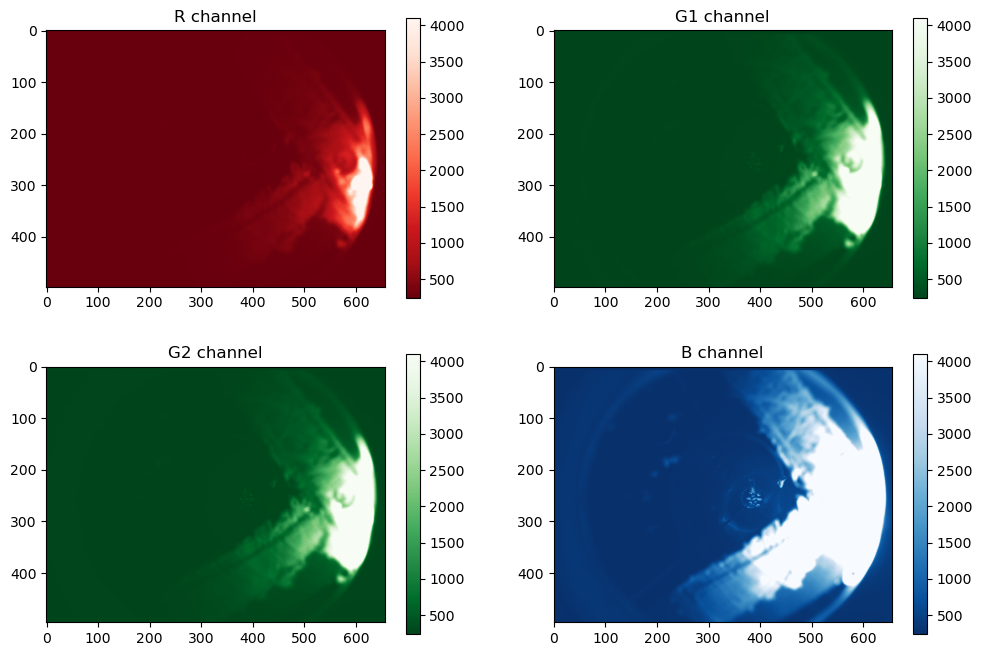

<Figure size 640x480 with 0 Axes>

In [26]:
R_channel = npy[0::2, 0::2]
G1_channel = npy[0::2, 1::2]
G2_channel = npy[1::2, 0::2]
B_channel = npy[1::2, 1::2]
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.title("R channel")
plt.imshow(R_channel, cmap='Reds_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title("G1 channel") 
plt.imshow(G1_channel, cmap='Greens_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title("G2 channel")
plt.imshow(G2_channel, cmap='Greens_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title("B channel")
plt.imshow(B_channel, cmap='Blues_r')
plt.colorbar()
plt.show()
plt.clf()

# Histogram

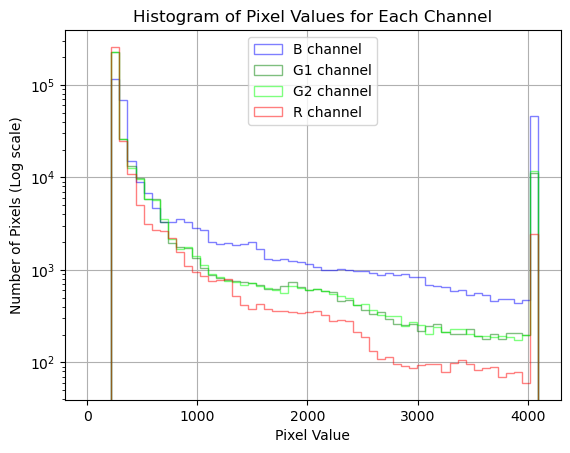

<Figure size 640x480 with 0 Axes>

In [27]:
B_channel = npy[1::2, 1::2].astype(np.float32).flatten()
G1_channel = npy[0::2, 1::2].astype(np.float32).flatten()
G2_channel = npy[1::2, 0::2].astype(np.float32).flatten()
R_channel = npy[0::2, 0::2].astype(np.float32).flatten()

plt.hist(B_channel, bins=56, range=(0,4095), color='b', alpha=0.5, label='B channel', histtype='step')
plt.hist(G1_channel, bins=56, range=(0,4095), color='g', alpha=0.5, label='G1 channel', histtype='step')
plt.hist(G2_channel, bins=56, range=(0,4095), color='lime', alpha=0.5, label='G2 channel', histtype='step')
plt.hist(R_channel, bins=56, range=(0,4095), color='r', alpha=0.5, label='R channel', histtype='step')
plt.yscale('log')
plt.xlabel('Pixel Value')
plt.ylabel('Number of Pixels (Log scale)')
plt.title('Histogram of Pixel Values for Each Channel')
plt.legend()
plt.grid(True)
plt.show()
plt.clf()

# Grayscale Image

Decompressing 1307462 bytes of compressed image data
image size: 1312 * 993


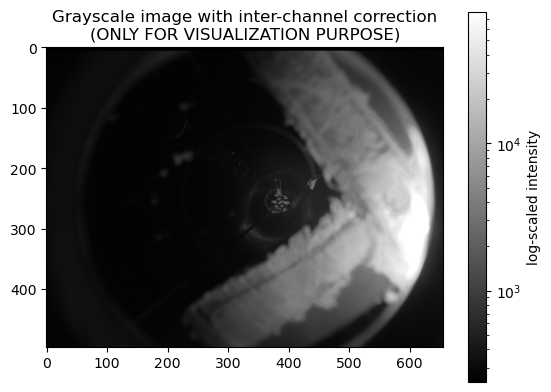

In [28]:
shape, npy = icuc.Raw2Npy(fname)
gray = icuc.get_gray(npy)

img = gray.astype(np.float32)

img_disp = np.maximum(img, 1e-3)

norm = colors.LogNorm(
    vmin=np.percentile(img_disp, 1),
    vmax=np.percentile(img_disp, 99)
)

plt.imshow(img_disp, cmap='gray', norm=norm)
plt.colorbar(label='log-scaled intensity')
plt.title('Grayscale image with inter-channel correction\n(ONLY FOR VISUALIZATION PURPOSE)')
plt.show()

# Simple Color Image

Decompressing 1307462 bytes of compressed image data
image size: 1312 * 993


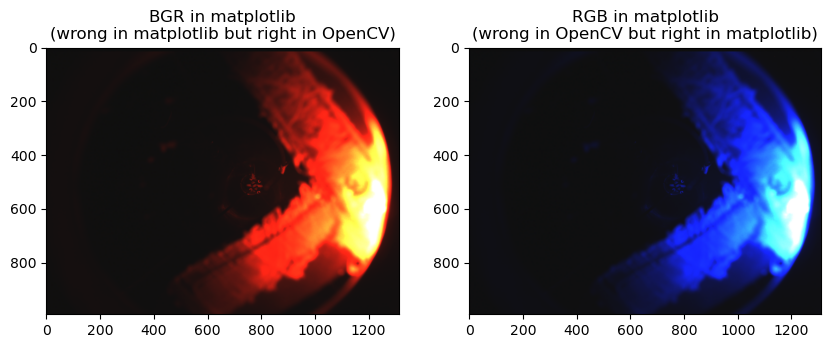

In [29]:
npy = icuc.Raw2Npy(fname)[1]
bgr = icuc.Npy2Bgr(npy)
rgb = icuc.Npy2Rgb(npy)
cv2.imwrite("./example_data/bgr_image.png", bgr)
cv2.imwrite("./example_data/rgb_image.png", rgb)

plt.figure(figsize=(10,10))
fig1 = plt.subplot(1,2,1)
fig1.imshow(bgr)
plt.title('BGR in matplotlib\n(wrong in matplotlib but right in OpenCV)')
fig2 = plt.subplot(1,2,2)
fig2.imshow(rgb)
plt.title('RGB in matplotlib\n(wrong in OpenCV but right in matplotlib)')
plt.show()

# Fit File

In [30]:
shape, npy = icuc.Raw2Npy(fname)
hdr_txt = icuc.header_info(fname)

hdu = fits.PrimaryHDU(npy)
hdr = hdu.header

# Bayer pattern metadata
hdr['BAYERPAT'] = 'RGGB'
hdr['XBAYROFF'] = 0
hdr['YBAYROFF'] = 0

# Optional but useful
#hdr['COLOR'] = True
hdr['BITPIX'] = 16

##other metadata for header
hdr['EXPTIME']= 0.1

###you can define any other header information here...
outname = "./example_data/example.fits"
hdu.writeto(outname, overwrite=True)

Decompressing 1307462 bytes of compressed image data
image size: 1312 * 993
Decompressing 1307462 bytes of compressed image data


# under dev. for better visualization

In [34]:
npy = icuc.Raw2Npy(fname)[1]
bgr16 = icuc.Npy2Bgr16(npy, bayer_code=cv2.COLOR_BAYER_BG2BGR)
##### asinh ############

bgr01_asinh = icuc.stretch_preserve_color(bgr16, p_black=0.1, p_white=99, a=40.0)
out8_asinh = icuc.to_uint8(bgr01_asinh)
out8_asinh_clahe = icuc.clahe_on_l_channel(out8_asinh, clipLimit=3.0)
bgr01_asinh_gamma = icuc.gamma(bgr01_asinh, gamma=0.7)
out8_asinh_gamma = icuc.to_uint8(bgr01_asinh_gamma)

cv2.imwrite(f"./example_data/dev/asinh.png", out8_asinh)
cv2.imwrite(f"./example_data/dev/asinh_clahe.png", out8_asinh_clahe)
cv2.imwrite(f"./example_data/dev/asinh_gamma.png", out8_asinh_gamma)

# log
bgr01_log = icuc.stretch_preserve_color_log(bgr16, p_black=0.1, p_white=99, k=400.0)
out8_log = icuc.to_uint8(bgr01_log)
out8_log_clahe = icuc.clahe_on_l_channel(out8_log, clipLimit=3.0)
bgr01_log_gamma = icuc.gamma(bgr01_log, gamma=0.7)
out8_log_gamma = icuc.to_uint8(bgr01_log_gamma)
cv2.imwrite(f"./example_data/dev/log.png", out8_log)
cv2.imwrite(f"./example_data/dev/log_clahe.png", out8_log_clahe)
cv2.imwrite(f"./example_data/dev/log_gamma.png", out8_log_gamma)

Decompressing 1307462 bytes of compressed image data
image size: 1312 * 993


True

Text(0.5, 1.0, 'LOG_GAMMA')

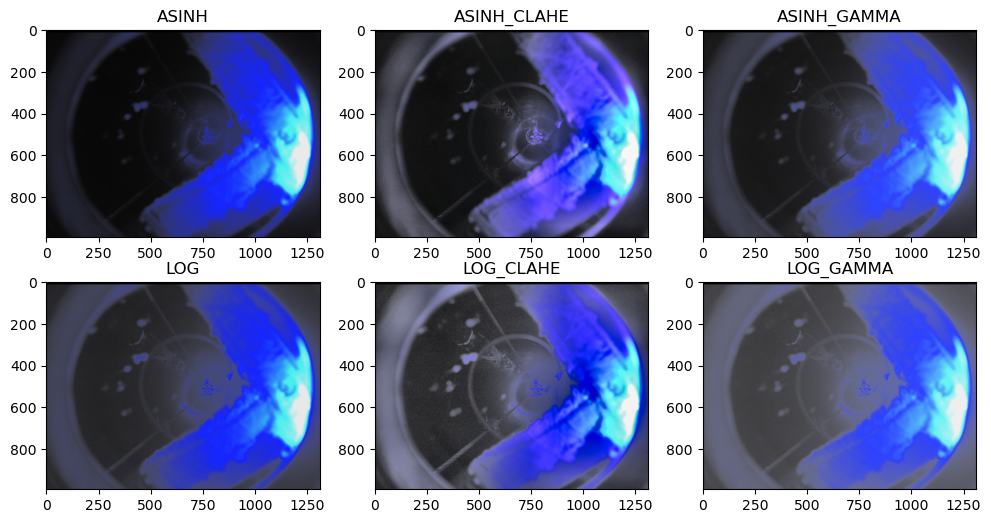

In [32]:
plt.figure(figsize=(12,6))
fig11=plt.subplot(2,3,1)
fig11.imshow(cv2.cvtColor(out8_asinh, cv2.COLOR_BGR2RGB))
plt.title("ASINH")
fig12=plt.subplot(2,3,2)
fig12.imshow(cv2.cvtColor(out8_asinh_clahe, cv2.COLOR_BGR2RGB))
plt.title("ASINH_CLAHE")
fig13=plt.subplot(2,3,3)
fig13.imshow(cv2.cvtColor(bgr01_asinh_gamma, cv2.COLOR_BGR2RGB))
plt.title("ASINH_GAMMA")

fig21=plt.subplot(2,3,4)
fig21.imshow(cv2.cvtColor(out8_log, cv2.COLOR_BGR2RGB))
plt.title("LOG")
fig22=plt.subplot(2,3,5)
fig22.imshow(cv2.cvtColor(out8_log_clahe, cv2.COLOR_BGR2RGB))
plt.title("LOG_CLAHE")
fig23=plt.subplot(2,3,6)
fig23.imshow(cv2.cvtColor(bgr01_log_gamma, cv2.COLOR_BGR2RGB))
plt.title("LOG_GAMMA")